In [1]:
import pandas as pd

data = pd.read_csv("F1_Master.csv")

data.head()

,resultId,raceId,year,circuitId,circuit_name,circuit_difficulty,driverId,driver_name,constructorId,constructor_name,starting_grid,final_position,points,pit_stops,pit_stop_lap,pit_stop_duration,fastestLapTime,fastestLapSpeed,statusId,race_status
0,1,18,2008,1,Australian Grand Prix,Very Easy,1,hamilton,1,mclaren,1,1,10.0,NaN,NaN,NaN,01:27.5,218.3,1,Finished
1,2,18,2008,1,Australian Grand Prix,Very Easy,2,heidfeld,2,bmw_sauber,5,2,8.0,NaN,NaN,NaN,01:27.7,217.586,1,Finished
2,3,18,2008,1,Australian Grand Prix,Very Easy,3,rosberg,3,williams,7,3,6.0,NaN,NaN,NaN,01:28.1,216.719,1,Finished
3,4,18,2008,1,Australian Grand Prix,Very Easy,4,alonso,4,renault,11,4,5.0,NaN,NaN,NaN,01:28.6,215.464,1,Finished
4,5,18,2008,1,Australian Grand Prix,Very Easy,5,kovalainen,1,mclaren,3,5,4.0,NaN,NaN,NaN,01:27.4,218.385,1,Finished


In [ ]:
data.info()

str

In [ ]:
sorted_drivers = sorted(data["driver_name"].unique())
print(len(sorted_drivers))
print(sorted_drivers)

857
['Cannoc', 'Changy', 'abate', 'abecassis', 'acheson', 'adamich', 'adams', 'ader', 'adolff', 'agabashian', 'ahrens', 'aitken', 'alan_brown', 'albers', 'albon', 'alboreto', 'alesi', 'alguersuari', 'alliot', 'allison', 'alonso', 'amati', 'ambrosio', 'amick', 'amon', 'anderson', 'andersson', 'andre_pilette', 'andretti', 'andrews', 'angelis', 'apicella', 'armi', 'arnold', 'arnoux', 'arundell', 'ascari', 'ashdown', 'ashley', 'ashmore', 'aston', 'attwood', 'ayulo', 'badoer', 'baghetti', 'bailey', 'baldi', 'ball', 'balsa', 'bandini', 'banks', 'barbazza', 'barber', 'barilla', 'barrichello', 'bartels', 'barth', 'bassi', 'bauer', 'baumgartner', 'bayol', 'beaufort', 'beauman', 'bechem', 'behra', 'bell', 'bellof', 'belmondo', 'belso', 'beltoise', 'beretta', 'berg', 'berger', 'bernard', 'bernoldi', 'bertaggia', 'bettenhausen', 'beuttler', 'bianchi', 'bianco', 'bill_moss', 'binder', 'biondetti', 'bira', 'birger', 'bisch', 'blanchard', 'bleekemolen', 'blignaut', 'blokdyk', 'blundell', 'bob_scott',

In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is already loaded and contains the relevant columns
# Example for loading, replace 'path_to_your_data.csv' with your actual data path:
df = pd.read_csv("F1_Master.csv")

# Convert fastest lap times from mm:ss.s format to total seconds
def convert_time_to_seconds(time_str):
    if pd.isna(time_str) or time_str == '\\N':
        return np.nan
    try:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    except ValueError:
        return np.nan

df['fastestLapTime'] = df['fastestLapTime'].apply(convert_time_to_seconds)

# Impute missing fastestLapTime values with the average for each driver
df['fastestLapTime'] = df.groupby('driver_name')['fastestLapTime'].transform(lambda x: x.fillna(x.mean()))

# Calculate node attributes for each driver
driver_stats = df.groupby('driver_name').agg(
    total_races=pd.NamedAgg(column='raceId', aggfunc='nunique'),
    podium_finishes=pd.NamedAgg(column='final_position', aggfunc=lambda x: (x <= 3).sum()),
    wins=pd.NamedAgg(column='final_position', aggfunc=lambda x: (x == 1).sum()),
    successful_finishes=pd.NamedAgg(column='race_status', aggfunc=lambda x: x.str.contains('Finished|^\+.*Laps$').sum()),
)
driver_stats['DNFs'] = driver_stats['total_races'] - driver_stats['successful_finishes']

# Create an empty directed graph
G = nx.DiGraph()

# Add node attributes
for driver, attrs in driver_stats.iterrows():
    G.add_node(driver, **attrs)

# Function to calculate average differences for directed edges
def calculate_avg_difference(sub_group, driver1, driver2, column):
    # Filter races for each driver
    driver1_races = sub_group[sub_group['driver_name'] == driver1]
    driver2_races = sub_group[sub_group['driver_name'] == driver2]
    
    # Calculate average values
    avg_driver1 = driver1_races[column].mean()
    avg_driver2 = driver2_races[column].mean()
    
    # Return the difference driver1 - driver2
    return avg_driver1 - avg_driver2 if not pd.isna(avg_driver1) and not pd.isna(avg_driver2) else np.nan

# Iterate over each group of (constructorId, year)
for (constructor, year), group in df.groupby(['constructorId', 'year']):
    drivers = group['driver_name'].unique()
    for i in range(len(drivers)):
        for j in range(i + 1, len(drivers)):
            sub_group = group[group['driver_name'].isin([drivers[i], drivers[j]])]
            if len(sub_group['raceId'].unique()) >= 2:
                # Calculate average position and other differences
                position_diff_i_to_j = calculate_avg_difference(sub_group, drivers[i], drivers[j], 'final_position')
                position_diff_j_to_i = calculate_avg_difference(sub_group, drivers[j], drivers[i], 'final_position')
                grid_diff_i_to_j = calculate_avg_difference(sub_group, drivers[i], drivers[j], 'starting_grid')
                grid_diff_j_to_i = calculate_avg_difference(sub_group, drivers[j], drivers[i], 'starting_grid')
                lap_time_diff_i_to_j = calculate_avg_difference(sub_group, drivers[i], drivers[j], 'fastestLapTime')
                lap_time_diff_j_to_i = calculate_avg_difference(sub_group, drivers[j], drivers[i], 'fastestLapTime')
                
                # Add directed edges with weights
                G.add_edge(drivers[i], drivers[j], constructor=group['constructor_name'].iloc[0],
                           avg_final_pos_diff=position_diff_i_to_j, avg_start_grid_diff=grid_diff_i_to_j,
                           avg_fastest_lap_time_diff=lap_time_diff_i_to_j)
                G.add_edge(drivers[j], drivers[i], constructor=group['constructor_name'].iloc[0],
                           avg_final_pos_diff=position_diff_j_to_i, avg_start_grid_diff=grid_diff_j_to_i,
                           avg_fastest_lap_time_diff=lap_time_diff_j_to_i)



In [37]:
edge_list = list(G.edges(data=True))

In [38]:
edge_list[0]

('Cannoc',
 'ganley',
 {'constructor': 'brm',
  'avg_final_pos_diff': 0.8181818181818183,
  'avg_start_grid_diff': 12.181818181818182,
  'avg_fastest_lap_time_diff': nan})

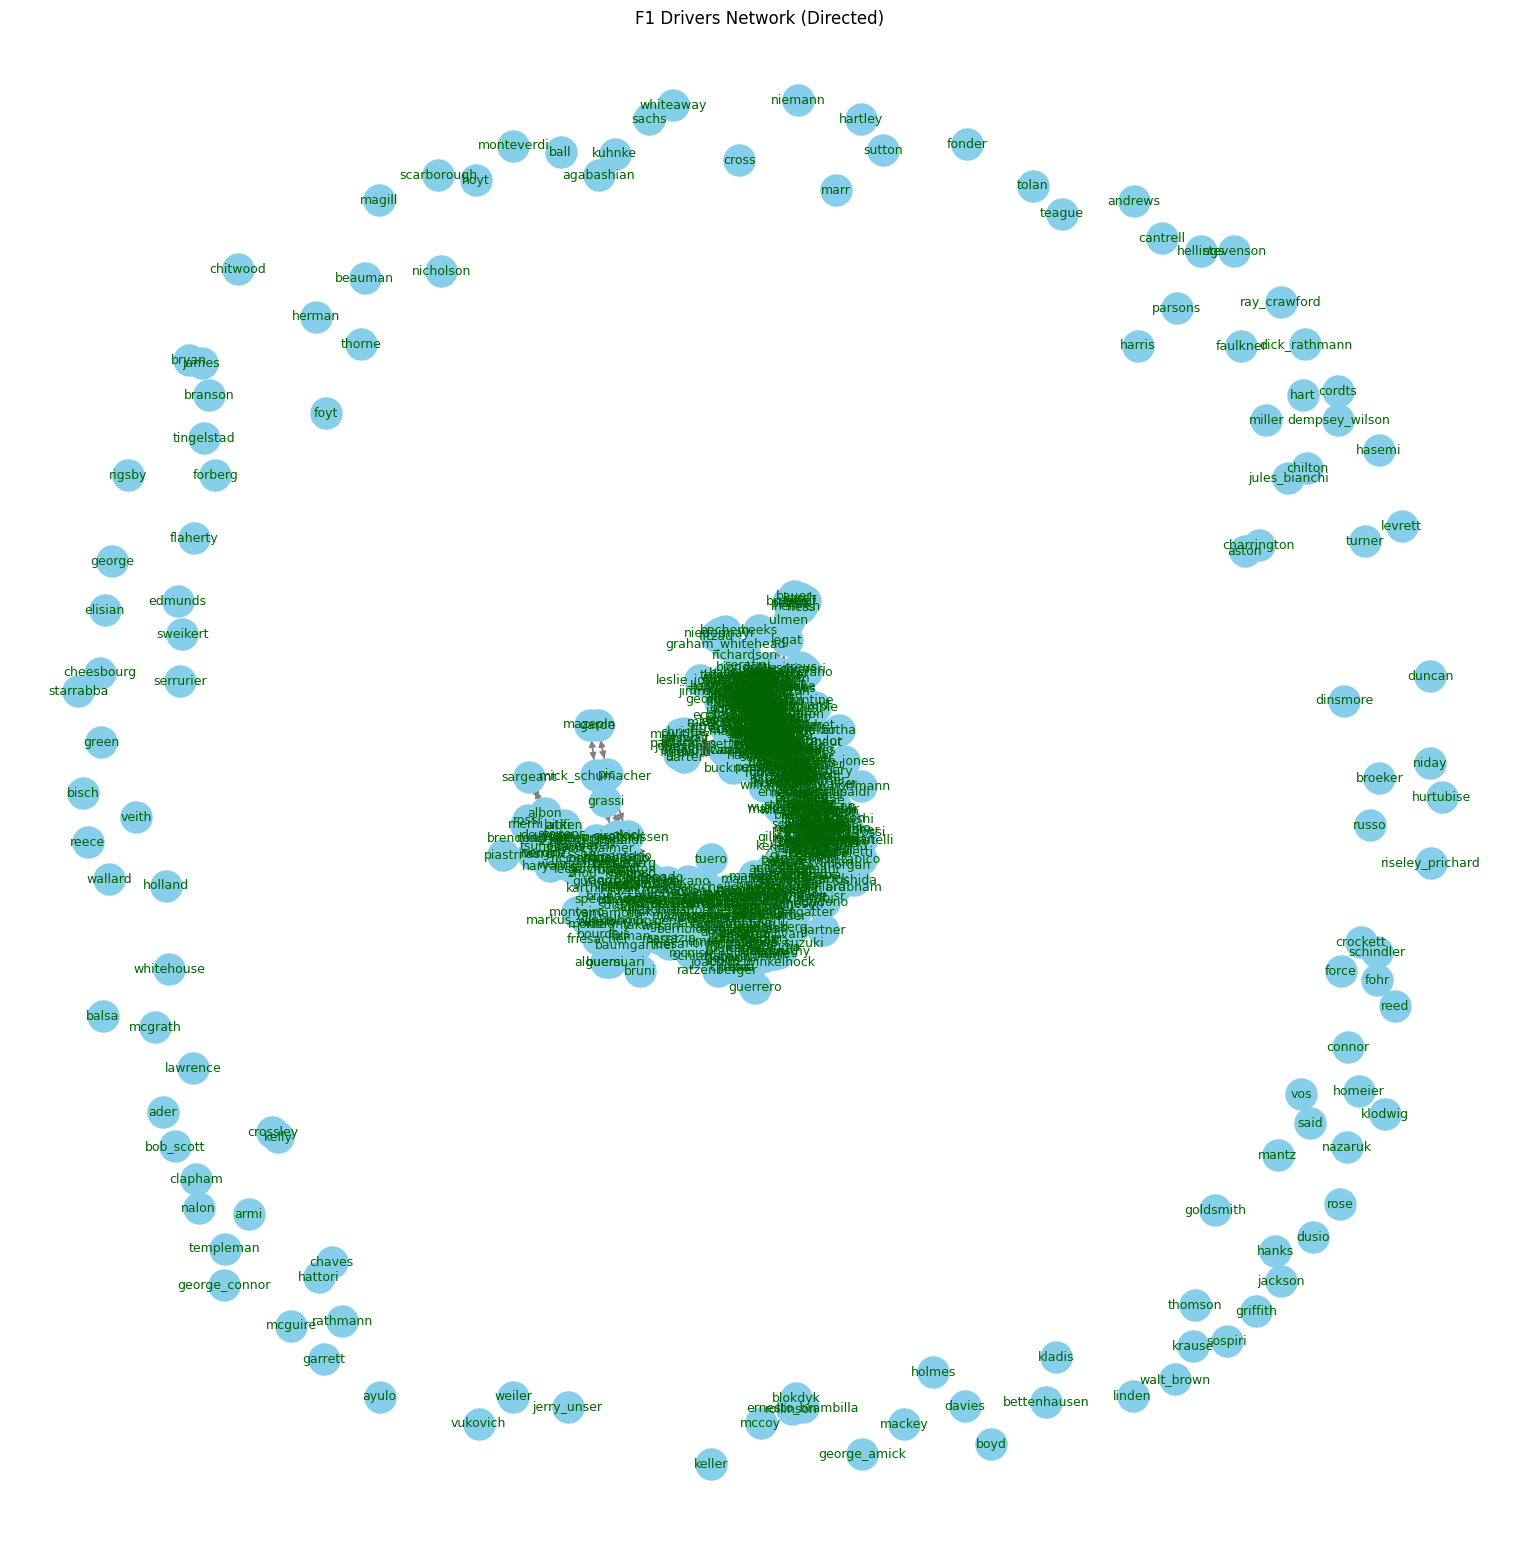

In [40]:
# Visualization
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=9, edge_color='gray', font_color='darkgreen')
plt.title('F1 Drivers Network (Directed)')
plt.show()